## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
import cv2

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
NET_MODEL_NO = 2
if NET_MODEL_NO == 0:
    from models_0 import Net
elif NET_MODEL_NO == 1:
    from models_1 import Net
elif NET_MODEL_NO == 2:
    from models_2 import Net
else:
    from models_3 import Net

# Instantiate the Net model
net = Net()
print(net)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop2): Dropout(p=0.15, inplace=False)
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop3): Dropout(p=0.2, inplace=False)
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop4): Dropout(p=0.25, inplace=False)
  (conv5): Sequential(
    (0): Conv2d(256, 512, kernel_size=

In [3]:
# Weight initialization from normal distribution
def weights_init_normal(model):
    """
    Applies initial weights to certain layers in a model.
    The weights are taken from a normal distribution with mean = 0, std dev = 0.02.
    :param model: A module or layer in a neural netowork model 
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = model.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    # for every Conv2d or ConvTranspose2d in a model
    # - model.weight.data is sampled from a normal distribution with mean = 0 and std_dev = 0.02
    # remark: bias is switched off here in the convolutional layers
    if classname.find('Conv') != -1:
        print('Updating weights for | ' + str(classname))
        #torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
        model.weight.data.normal_(0.0, 0.02)        
        model.bias.data.fill_(0.0)
    
    # for every Linear layer in a model
    # - model.weight.data is sampled from a normal distribution with mean = 0 and std_dev = 0.02
    # - model.bias.data is set to zero
    if classname.find('Linear') != -1:
        print('Updating weights for | ' + str(classname))
        #torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
        model.weight.data.normal_(0.0, 0.02)
        model.bias.data.fill_(0.0)

# Weight initialization using Xavier / Glorot method sampling from a uniform distribution
def weights_init_xavier_uniform(model):
    """
    Applies initial weights to certain layers in a model.
    The weights are filled in using a uniform distribution according to the method described in 
    "Understanding the difficulty of training deep feedforward neural networks" by Glorot, X. 
    and Bengio, Y. (2010). The resulting tensor will have values sampled from a distribution 
    U(−a,a) where a = gain x sqrt(6 / (fan_in+fan_out). Also known as Glorot initialization.
    :param model: A module or layer in a neural netowork model  
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = model.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    # for every Conv2d or ConvTranspose2d in a model
    # - model.weight.data are filled in using Xavier Glorot initialization method
    # remark: bias is switched off here in the convolutional layers
    if classname.find('Conv') != -1:
        print('Updating weights for | ' + str(classname))
        nn.init.xavier_uniform_(model.weight.data, 
                               gain=nn.init.calculate_gain('relu')) # elu not supported => use relu
        model.bias.data.fill_(0.0)
    
    # for every Linear layer in a model
    # - model.weight.data are filled in using Xavier Glorot initialization method
    # - model.bias.data is set to zero
    if classname.find('Linear') != -1:
        print('Updating weights for | ' + str(classname))
        if classname.find('leaky_relu') != -1:
            nn.init.xavier_uniform_(model.weight.data,
                                    gain=nn.init.calculate_gain('leaky_relu', 0.01))
        elif classname.find('relu') != -1:
            nn.init.xavier_normal_(model.weight.data,
                                   gain=nn.init.calculate_gain('relu'))
        else:
            nn.init.xavier_normal_(model.weight.data,
                                   gain=1.0)
        model.bias.data.fill_(0.0)

# Weight initialization using Xavier / Glorot method sampling from a normal distribution
def weights_init_xavier_normal(model):
    """
    Applies initial weights to certain layers in a model.
    The weights are filled in using a normal distribution according to the method described in 
    "Understanding the difficulty of training deep feedforward neural networks" by Glorot, X. 
    and Bengio, Y. (2010). The resulting tensor will have values sampled from N(0,std²) where
    std = gain x sqrt(2 / (fan_in+fan_out). Also known as Glorot initialization.
    :param model: A module or layer in a neural netowork model      
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = model.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    # for every Conv2d or ConvTranspose2d in a model
    # - model.weight.data are filled in using Xavier Glorot initialization method
    # remark: bias is switched off here in the convolutional layers
    if classname.find('Conv') != -1:
        print('Updating weights for | ' + str(classname))
        nn.init.xavier_normal_(model.weight.data, 
                               gain=nn.init.calculate_gain('relu')) # elu not supported => use relu
        model.bias.data.fill_(0.0)
    
    # for every Linear layer in a model
    # - model.weight.data are filled in using Xavier Glorot initialization method
    # - model.bias.data is set to zero
    if classname.find('Linear') != -1:
        print('Updating weights for | ' + str(classname))
        if classname.find('leaky_relu') != -1:
            nn.init.xavier_normal_(model.weight.data,
                                   gain=nn.init.calculate_gain('leaky_relu', 0.01))
        elif classname.find('relu') != -1:
            nn.init.xavier_normal_(model.weight.data,
                                   gain=nn.init.calculate_gain('relu'))
        else:
            nn.init.xavier_normal_(model.weight.data,
                                   gain=1.0)
        model.bias.data.fill_(0.0)

In [4]:
# Initialize model weights using one of the below methods (else use pytorch's default method)
# net.apply(weights_init_normal) # normal distribution
# net.apply(weights_init_xavier_uniform) # Xavier/Glorot method with uniform distribution
# net.apply(weights_init_xavier_normal) # Xavier/Glorot method with normal distribution

In [5]:
# Check if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('GPU is available => Train on GPU using CUDA.')
    # Move Net model to cuda if GPU is available
    net.cuda()
    print('Net model moved to device.')
else:
    print(' GPU is not available => Train on CPU')

GPU is available => Train on GPU using CUDA.
Net model moved to device.


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(256),
                                     RandomCrop(224),
                                     Normalize(), # Do NOT apply Normalize() before Rescale() or RandomCrop()!
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [7]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)

# iterate through the transformed dataset and print some stats about the first few samples
print('Number of images in the transformed dataset: ', len(transformed_dataset))
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images in the transformed dataset:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [8]:
# Split transformed dataset into training and validation set at a ratio 9 : 1
train_length = int(0.9245 * len(transformed_dataset)) # train: 3200 | valid: 262
# train_length = int(0.913 * len(transformed_dataset)) # train: 3160 | valid: 302
valid_length = len(transformed_dataset) - train_length
train_dataset, valid_dataset = torch.utils.data.random_split(transformed_dataset, (train_length, valid_length))

# Print length of training and validation dataset
print('Number of images in off-split training dataset:   {:>4}'.format(train_length))
print('Number of images in off-split validation dataset: {:>4}'.format(valid_length))

Number of images in off-split training dataset:   3200
Number of images in off-split validation dataset:  262


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [9]:
# load training and validation data in batches
batch_size = 16

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(valid_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [10]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)

In [11]:
# load test data in batches
batch_size = 16

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [12]:
# test the model on a batch of test images

def net_sample_output():
    
    # Switch off gradients for efficient prediction
    with torch.no_grad():
        
        # Set model to evaluation mode
        net.eval()
        
        # iterate through the test dataset
        for i, sample in enumerate(test_loader):
            
            # get sample data: images and ground truth keypoints
            images = sample['image']
            key_pts = sample['keypoints']
            
            # convert images to FloatTensors and move to cuda if available
            if use_cuda:
                images = images.type(torch.FloatTensor).cuda()
            else:
                images = images.type(torch.FloatTensor)
            
            # forward pass to get net output
            output_pts = net(images)
            
            # reshape to batch_size x 68 x 2 pts
            output_pts = output_pts.view(output_pts.size()[0], 68, -1)
            
            # Copy images and output_pts tensors back to CPU if they are not there yet
            images = images.cpu()
            output_pts = output_pts.detach().cpu() # remove "requires gradients" by detaching
            
            # break after first image batch is tested
            if i == 0:
                return images, output_pts, key_pts

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [13]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, test_gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(test_gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [14]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

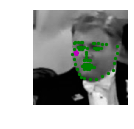

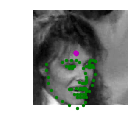

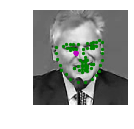

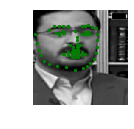

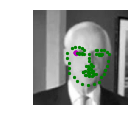

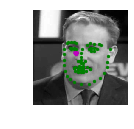

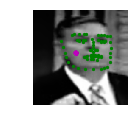

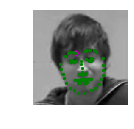

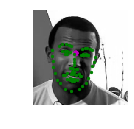

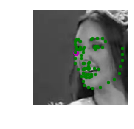

In [15]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, test_gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)
        
        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image
                
        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_key_pts = None
        if test_gt_pts is not None:
            # un-transform the ground truth key_pts data
            ground_truth_key_pts = test_gt_pts[i].data
            ground_truth_key_pts = ground_truth_key_pts.numpy()
            # undo normalization of keypoints
            ground_truth_key_pts = ground_truth_key_pts*50.0+100
                
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_key_pts)
        
        plt.axis('off')
        
    plt.show()
    
# visualize one batch of test images
visualize_output(test_images, test_outputs, test_gt_pts, batch_size=10)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [16]:
## TODO: Define the loss and optimization
import torch.optim as optim
from torch.optim import lr_scheduler

# nn.SmoothL1Loss() creates a criterion that uses a squared term if the absolute element-wise error 
# falls below 1 and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in 
# some cases prevents exploding gradients (e.g. see Fast R-CNN paper by Ross Girshick). Also known 
# as the Huber loss.
criterion = nn.SmoothL1Loss()

# nn.MSELoss() creates a criterion that measures the mean squared error (squared L2 norm) between 
# each element in the input xxx and target yyy.
# criterion = nn.MSELoss()


# Select optimizer
selected_optimizer = 'Adam'
# selected_optimizer = 'SGD' # leads to accumulated keypoint clouds => seems not useful for this task => use Adam

# Create optimizers for the discriminator and generator
if selected_optimizer == 'Adam':
    
    # Optimization parameters for Adam optimizer
    # lr = 5e-2            # learning rate (default: 1e-3)
    # lr = 1e-2            # learning rate (default: 1e-3)
    # lr = 5e-3            # learning rate (default: 1e-3)
    # lr = 2e-3              # learning rate (default: 1e-3)
    lr = 1e-3            # learning rate (default: 1e-3)
    # lr = 5e-4            # learning rate (default: 1e-3)
    # lr = 5e-2            # learning rate (default: 1e-3)
    # lr = 1e-4            # learning rate (default: 1e-3)
    beta1 = 0.5          # lower beta coefficient for computing running averages of gradient and its square (default: 0.9
    beta2 = 0.999        # upper beta coefficient for computing running averages of gradient and its square (default: 0.999)
    eps = 1e-08          # term added to the denominator to improve numerical stability (default: 1e-8)
    #weight_decay = 0.0   # weight decay resp. L2 penalty (default: 0)
    weight_decay = 1e-07 # weight decay resp. L2 penalty (default: 0)
    # weight_decay = 1e-08 # weight decay resp. L2 penalty (default: 0)

    # Create optimizer for the CNN model built from scratch
    optimizer = optim.Adam(net.parameters(), lr, [beta1, beta2], eps, weight_decay)
    
    # Create scheduler for learning rate decay by a factor of 0.5 every x epochs
    # lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)
    lr_scheduler = None
    
elif selected_optimizer == 'SGD':
    
    # Optimization parameters for stochastic gradient descent (SGD) optimizer
    # lr = 5e-2            # learning rate
    # lr = 1e-2            # learning rate
    # lr = 5e-3            # learning rate
    # lr = 2e-3            # learning rate
    lr = 1e-3            # learning rate
    # lr = 1e-4            # learning rate
    momentum = 0.0       # momentum factor (default: 0.0)
    # momentum = 0.4       # momentum factor (default: 0.0)
    dampening = 0.0      # dampening for momentum (default: 0.0)
    # dampening = 0.1      # dampening for momentum (default: 0.0)
    weight_decay = 0.0   # weight decay resp. L2 penalty (default: 0.0)
    # weight_decay = 1e-7  # weight decay resp. L2 penalty (default: 0.0)
    # weight_decay = 1e-8  # weight decay resp. L2 penalty (default: 0.0)

    # Create optimizer for the CNN model built from scratch
    optimizer = optim.SGD(net.parameters(), lr, momentum, dampening, weight_decay)
    
    # Create scheduler for learning rate decay by a factor of 0.5 every x epochs
    # lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    lr_scheduler = None

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [17]:
## TODO: change the name to something uniqe for each new model
# The best keypoint model will be stored automatically during training upon decrease of validation loss 
# under the below declared directory and model name

# set model directory
model_dir = 'saved_models/'

# set model name
if NET_MODEL_NO == 0:
    # model name for model 0 and minimum validation loss
    model_name_min_loss = 'keypoints_model_0_min_loss.pt'
    # model name for model 1 and last state after training
    model_name_last_state = 'keypoints_model_0_last_state.pt'
elif NET_MODEL_NO == 1:
    # model name for model 1 and minimum validation loss
    model_name_min_loss = 'keypoints_model_1_min_loss.pt'
    # model name for model 1 and last state after training
    model_name_last_state = 'keypoints_model_1_last_state.pt'
elif NET_MODEL_NO == 2:
    # model name for model 2 and minimum validation loss
    model_name_min_loss = 'keypoints_model_2_min_loss.pt'
    # model name for model 2 and last state after training
    model_name_last_state = 'keypoints_model_2_last_state.pt'
else:
    # model name for model 3 and minimum validation loss
    model_name_min_loss = 'keypoints_model_3_min_loss.pt'
    # model name for model 3 and last state after training
    model_name_last_state = 'keypoints_model_3_last_state.pt'

# set model path for minimum validation loss
model_path_min_loss = model_dir + model_name_min_loss

# set model path for last state after all training epochs
model_path_last_state = model_dir + model_name_last_state

In [18]:
def train_net(n_epochs,
              train_loader,
              valid_loader,
              model,
              optimizer,
              criterion,
              scheduler,
              use_cuda,
              model_path_min_loss,
              model_path_last_state):
    
    # prepare the net model for training
    model.train()
    
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    # initialize variables to monitor the history of average training and validation loss
    train_loss_history = np.zeros(n_epochs)
    valid_loss_history = np.zeros(n_epochs)
    
    # start training
    print('\nStart training ...\n')
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
                
        # Initialize average running training and validation loss
        running_train_loss = 0.0
        running_valid_loss = 0.0
        
        #######################
        # train the Net model #
        #######################
        
        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten keypoint array
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to float tensors for regression loss and move to cuda if available
            if use_cuda:
                key_pts = key_pts.type(torch.FloatTensor).cuda()
                images = images.type(torch.FloatTensor).cuda()
            else:
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)
                
            # forward pass to get predicted outputs
            output_pts = model(images)

            # calculate the training loss between predicted and target keypoints
            train_batch_loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients for each new batch
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            train_batch_loss.backward()

            # update the weights
            optimizer.step()
            
            # Adapt optimization parameters (call after optimization step has been performed)
            if scheduler is not None:
                scheduler.step()
            
            # convert current train_batch_loss into a scalar and add it to the avg. running_train_loss, use .item()
            running_train_loss = (running_train_loss * batch_i + train_batch_loss.item()) / (batch_i + 1)
            
            # store the average training loss of the current epoch
            train_loss_history[epoch] = running_train_loss
            
            # print training loss statistics
            if batch_i % 10 == 9:    # print training loss every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Training Loss: {}'.format(epoch + 1, 
                                                                            batch_i+1, 
                                                                            running_train_loss))
            
        ##########################    
        # validate the Net model #
        ##########################
        
        # set net model to evaluation mode
        model.eval()
        
        # validate on batches of data, assumes you already have valid loader
        for batch_i, data in enumerate(valid_loader):
            
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten keypoint array
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to float tensors for regression loss and move to cuda if available
            if use_cuda:
                key_pts = key_pts.type(torch.FloatTensor).cuda()
                images = images.type(torch.FloatTensor).cuda()
            else:
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)
            
            # forward pass to get predicted outputs
            output_pts = model(images)

            # calculate the validation batch loss between predicted and target keypoints
            valid_batch_loss = criterion(output_pts, key_pts)
            
            # convert current valid_batch_loss into a scalar and add it to the avg. running_valid_loss, use .item()
            running_valid_loss = (running_valid_loss * batch_i + valid_batch_loss.item()) / (batch_i + 1)
            
            # store the average validation loss of the current epoch
            valid_loss_history[epoch] = running_valid_loss
            
            # print validation loss statistics
            if batch_i % 10 == 9:    # print validation loss every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Validation Loss: {}'.format(epoch + 1, 
                                                                              batch_i+1, 
                                                                              running_valid_loss))
            
        # print training and validation loss statistics per epoch
        print('\nEpoch: {}, Avg. Training Loss: {} Avg. Validation Loss: {}\n'.format(epoch + 1, 
                                                                                    running_train_loss, 
                                                                                    running_valid_loss))
        
        ## TODO: save the net if validation loss has decreased
        if running_valid_loss <= valid_loss_min:
            print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving net ...\n'.format(
                valid_loss_min,
                running_valid_loss))
            # save the net model parameters with minimum validation loss as state dictionary under the given path
            torch.save(model.state_dict(), model_path_min_loss)
            # Update minimum validation loss achieved so far
            valid_loss_min = running_valid_loss
        
        # set net model back to training mode
        model.eval()
    
    # Print final message upon finishing training process
    print('\n... training finished.\n')
    
    # save the net model parameter of last state of the training process as state directory under the given path
    print('\tMinimum validation loss so far: {:.6f}.\n'.format(valid_loss_min))
    print('\tValidation loss of last state: {:.6f}.  Saving net ...\n'.format(running_valid_loss))
    torch.save(model.state_dict(), model_path_last_state)
    
    # Return the last state of trained net model plus training and validation loss history
    return model, train_loss_history, valid_loss_history

In [19]:
import time

# number of training epochs
n_epochs = 100 # start small, and increase when you've decided on your model structure and hyperparams

# start timer
start_time = time.time()

# train the cnn model
net, train_loss_history, valid_loss_history = train_net(n_epochs,
                                                        train_loader,
                                                        valid_loader,
                                                        net,
                                                        optimizer,
                                                        criterion,
                                                        lr_scheduler,
                                                        use_cuda,
                                                        model_path_min_loss,
                                                        model_path_last_state)

# get stop time
stop_time = time.time()

# evaluate elapsed time
elapsed_time = stop_time - start_time
print('\tElapsed time: {:.0f} h {:.0f} min {:.0f} s\n'.format(elapsed_time//3600, 
                                                            (elapsed_time%3600)//60,
                                                            (elapsed_time%3600)%60))


Start training ...

Epoch: 1, Batch: 10, Avg. Training Loss: 0.2103777125477791
Epoch: 1, Batch: 20, Avg. Training Loss: 0.18387992046773433
Epoch: 1, Batch: 30, Avg. Training Loss: 0.167861457914114
Epoch: 1, Batch: 40, Avg. Training Loss: 0.16143170092254877
Epoch: 1, Batch: 50, Avg. Training Loss: 0.15848815634846689
Epoch: 1, Batch: 60, Avg. Training Loss: 0.15385625027120114
Epoch: 1, Batch: 70, Avg. Training Loss: 0.1529409693820136
Epoch: 1, Batch: 80, Avg. Training Loss: 0.15123356375843283
Epoch: 1, Batch: 90, Avg. Training Loss: 0.15009479373693463
Epoch: 1, Batch: 100, Avg. Training Loss: 0.14770977452397344
Epoch: 1, Batch: 110, Avg. Training Loss: 0.14600743678483097
Epoch: 1, Batch: 120, Avg. Training Loss: 0.14333056869606178
Epoch: 1, Batch: 130, Avg. Training Loss: 0.1398790893646387
Epoch: 1, Batch: 140, Avg. Training Loss: 0.13789691909083296
Epoch: 1, Batch: 150, Avg. Training Loss: 0.13603485931952794
Epoch: 1, Batch: 160, Avg. Training Loss: 0.1332381468266248
Ep

Epoch: 6, Batch: 170, Avg. Training Loss: 0.028449521345250743
Epoch: 6, Batch: 180, Avg. Training Loss: 0.02844817744981911
Epoch: 6, Batch: 190, Avg. Training Loss: 0.029129232319169918
Epoch: 6, Batch: 200, Avg. Training Loss: 0.02867777581326663
Epoch: 6, Batch: 10, Avg. Validation Loss: 0.02275511883199215

Epoch: 6, Avg. Training Loss: 0.02867777581326663 Avg. Validation Loss: 0.026082372950280413

	Validation loss decreased (0.029232 --> 0.026082).  Saving net ...

Epoch: 7, Batch: 10, Avg. Training Loss: 0.023245017789304257
Epoch: 7, Batch: 20, Avg. Training Loss: 0.02691453364677727
Epoch: 7, Batch: 30, Avg. Training Loss: 0.023908752451340356
Epoch: 7, Batch: 40, Avg. Training Loss: 0.028210382955148817
Epoch: 7, Batch: 50, Avg. Training Loss: 0.026265918482095002
Epoch: 7, Batch: 60, Avg. Training Loss: 0.026504354365170003
Epoch: 7, Batch: 70, Avg. Training Loss: 0.025668103114834855
Epoch: 7, Batch: 80, Avg. Training Loss: 0.02507458165055142
Epoch: 7, Batch: 90, Avg. Tra

Epoch: 12, Batch: 70, Avg. Training Loss: 0.020463710737281614
Epoch: 12, Batch: 80, Avg. Training Loss: 0.02035890379338525
Epoch: 12, Batch: 90, Avg. Training Loss: 0.02521750303502712
Epoch: 12, Batch: 100, Avg. Training Loss: 0.025158464103005828
Epoch: 12, Batch: 110, Avg. Training Loss: 0.02451162675649605
Epoch: 12, Batch: 120, Avg. Training Loss: 0.024175957314825306
Epoch: 12, Batch: 130, Avg. Training Loss: 0.023374043859971258
Epoch: 12, Batch: 140, Avg. Training Loss: 0.022939978955712703
Epoch: 12, Batch: 150, Avg. Training Loss: 0.02261034723060827
Epoch: 12, Batch: 160, Avg. Training Loss: 0.022151943683275027
Epoch: 12, Batch: 170, Avg. Training Loss: 0.02172505702987752
Epoch: 12, Batch: 180, Avg. Training Loss: 0.021311066597182723
Epoch: 12, Batch: 190, Avg. Training Loss: 0.020737782659891398
Epoch: 12, Batch: 200, Avg. Training Loss: 0.020433996529318384
Epoch: 12, Batch: 10, Avg. Validation Loss: 0.01561104697175324

Epoch: 12, Avg. Training Loss: 0.02043399652931


Epoch: 17, Avg. Training Loss: 0.008628461827756834 Avg. Validation Loss: 0.01580944410799181

Epoch: 18, Batch: 10, Avg. Training Loss: 0.00655704727396369
Epoch: 18, Batch: 20, Avg. Training Loss: 0.008760231966152787
Epoch: 18, Batch: 30, Avg. Training Loss: 0.008712904853746295
Epoch: 18, Batch: 40, Avg. Training Loss: 0.008585924794897438
Epoch: 18, Batch: 50, Avg. Training Loss: 0.009181798277422788
Epoch: 18, Batch: 60, Avg. Training Loss: 0.008747053580979507
Epoch: 18, Batch: 70, Avg. Training Loss: 0.008454476543036955
Epoch: 18, Batch: 80, Avg. Training Loss: 0.008164129214128478
Epoch: 18, Batch: 90, Avg. Training Loss: 0.008052521928523978
Epoch: 18, Batch: 100, Avg. Training Loss: 0.008229370047338307
Epoch: 18, Batch: 110, Avg. Training Loss: 0.008457534561272373
Epoch: 18, Batch: 120, Avg. Training Loss: 0.008311208713954937
Epoch: 18, Batch: 130, Avg. Training Loss: 0.008129567387872018
Epoch: 18, Batch: 140, Avg. Training Loss: 0.008036665678290386
Epoch: 18, Batch: 

Epoch: 23, Batch: 150, Avg. Training Loss: 0.00908801634795963
Epoch: 23, Batch: 160, Avg. Training Loss: 0.00886508097028126
Epoch: 23, Batch: 170, Avg. Training Loss: 0.008896426723667356
Epoch: 23, Batch: 180, Avg. Training Loss: 0.008948094388728744
Epoch: 23, Batch: 190, Avg. Training Loss: 0.008779150229192477
Epoch: 23, Batch: 200, Avg. Training Loss: 0.008611464906716713
Epoch: 23, Batch: 10, Avg. Validation Loss: 0.009025930752977728

Epoch: 23, Avg. Training Loss: 0.008611464906716713 Avg. Validation Loss: 0.007614977849537835

Epoch: 24, Batch: 10, Avg. Training Loss: 0.004237070097588003
Epoch: 24, Batch: 20, Avg. Training Loss: 0.0064330084016546605
Epoch: 24, Batch: 30, Avg. Training Loss: 0.022280187609915934
Epoch: 24, Batch: 40, Avg. Training Loss: 0.03695567258400843
Epoch: 24, Batch: 50, Avg. Training Loss: 0.03412761046551168
Epoch: 24, Batch: 60, Avg. Training Loss: 0.03014534633451452
Epoch: 24, Batch: 70, Avg. Training Loss: 0.026787141863522785
Epoch: 24, Batch:

Epoch: 29, Batch: 80, Avg. Training Loss: 0.00982536431984045
Epoch: 29, Batch: 90, Avg. Training Loss: 0.009414634005063113
Epoch: 29, Batch: 100, Avg. Training Loss: 0.008919801448937507
Epoch: 29, Batch: 110, Avg. Training Loss: 0.008482751074585727
Epoch: 29, Batch: 120, Avg. Training Loss: 0.00812352505551341
Epoch: 29, Batch: 130, Avg. Training Loss: 0.007987488299393313
Epoch: 29, Batch: 140, Avg. Training Loss: 0.008372591743578338
Epoch: 29, Batch: 150, Avg. Training Loss: 0.008183853289422892
Epoch: 29, Batch: 160, Avg. Training Loss: 0.007995945279253649
Epoch: 29, Batch: 170, Avg. Training Loss: 0.0077791577095494575
Epoch: 29, Batch: 180, Avg. Training Loss: 0.00764328928328016
Epoch: 29, Batch: 190, Avg. Training Loss: 0.007513050677401849
Epoch: 29, Batch: 200, Avg. Training Loss: 0.007476347752381119
Epoch: 29, Batch: 10, Avg. Validation Loss: 0.007039951230399311

Epoch: 29, Avg. Training Loss: 0.007476347752381119 Avg. Validation Loss: 0.012525997384834816

Epoch: 30,

Epoch: 35, Batch: 10, Avg. Training Loss: 0.006857457826845348
Epoch: 35, Batch: 20, Avg. Training Loss: 0.0062252515461295845
Epoch: 35, Batch: 30, Avg. Training Loss: 0.006073571415618062
Epoch: 35, Batch: 40, Avg. Training Loss: 0.005875220033340156
Epoch: 35, Batch: 50, Avg. Training Loss: 0.0059251174982637165
Epoch: 35, Batch: 60, Avg. Training Loss: 0.005816101764018337
Epoch: 35, Batch: 70, Avg. Training Loss: 0.005638456637305873
Epoch: 35, Batch: 80, Avg. Training Loss: 0.0054971494973869986
Epoch: 35, Batch: 90, Avg. Training Loss: 0.005460017311593723
Epoch: 35, Batch: 100, Avg. Training Loss: 0.00535059819696471
Epoch: 35, Batch: 110, Avg. Training Loss: 0.005283227418972686
Epoch: 35, Batch: 120, Avg. Training Loss: 0.005263413867214694
Epoch: 35, Batch: 130, Avg. Training Loss: 0.005212628146490225
Epoch: 35, Batch: 140, Avg. Training Loss: 0.005218574333204222
Epoch: 35, Batch: 150, Avg. Training Loss: 0.005189843452535569
Epoch: 35, Batch: 160, Avg. Training Loss: 0.00

Epoch: 40, Batch: 170, Avg. Training Loss: 0.007758739101700481
Epoch: 40, Batch: 180, Avg. Training Loss: 0.00761621508799079
Epoch: 40, Batch: 190, Avg. Training Loss: 0.007728406061467368
Epoch: 40, Batch: 200, Avg. Training Loss: 0.007821663655340668
Epoch: 40, Batch: 10, Avg. Validation Loss: 0.009534144308418036

Epoch: 40, Avg. Training Loss: 0.007821663655340668 Avg. Validation Loss: 0.009041960186818066

Epoch: 41, Batch: 10, Avg. Training Loss: 0.006252009561285377
Epoch: 41, Batch: 20, Avg. Training Loss: 0.005843642202671618
Epoch: 41, Batch: 30, Avg. Training Loss: 0.005436586767124633
Epoch: 41, Batch: 40, Avg. Training Loss: 0.005093987251166254
Epoch: 41, Batch: 50, Avg. Training Loss: 0.005190409841015935
Epoch: 41, Batch: 60, Avg. Training Loss: 0.007875646674074232
Epoch: 41, Batch: 70, Avg. Training Loss: 0.007889858214184644
Epoch: 41, Batch: 80, Avg. Training Loss: 0.007802885182900357
Epoch: 41, Batch: 90, Avg. Training Loss: 0.007898126459783978
Epoch: 41, Batch

Epoch: 46, Batch: 110, Avg. Training Loss: 0.007087764715437183
Epoch: 46, Batch: 120, Avg. Training Loss: 0.006912311948447798
Epoch: 46, Batch: 130, Avg. Training Loss: 0.0068716615474281395
Epoch: 46, Batch: 140, Avg. Training Loss: 0.07677450755145401
Epoch: 46, Batch: 150, Avg. Training Loss: 0.07506736354591942
Epoch: 46, Batch: 160, Avg. Training Loss: 0.07215760186372785
Epoch: 46, Batch: 170, Avg. Training Loss: 0.06912990168339624
Epoch: 46, Batch: 180, Avg. Training Loss: 0.06645673673030812
Epoch: 46, Batch: 190, Avg. Training Loss: 0.06365357468296816
Epoch: 46, Batch: 200, Avg. Training Loss: 0.06105801845202215
Epoch: 46, Batch: 10, Avg. Validation Loss: 0.014218906173482537

Epoch: 46, Avg. Training Loss: 0.06105801845202215 Avg. Validation Loss: 0.013139600701191845

Epoch: 47, Batch: 10, Avg. Training Loss: 0.0311933449935168
Epoch: 47, Batch: 20, Avg. Training Loss: 0.02200944295618683
Epoch: 47, Batch: 30, Avg. Training Loss: 0.01850958770761887
Epoch: 47, Batch: 40

Epoch: 52, Batch: 60, Avg. Training Loss: 0.004342755388158062
Epoch: 52, Batch: 70, Avg. Training Loss: 0.004348257889172859
Epoch: 52, Batch: 80, Avg. Training Loss: 0.004251007075072264
Epoch: 52, Batch: 90, Avg. Training Loss: 0.004224096122197803
Epoch: 52, Batch: 100, Avg. Training Loss: 0.0041549953282810715
Epoch: 52, Batch: 110, Avg. Training Loss: 0.004182434884238646
Epoch: 52, Batch: 120, Avg. Training Loss: 0.004407809517579149
Epoch: 52, Batch: 130, Avg. Training Loss: 0.004331915470986408
Epoch: 52, Batch: 140, Avg. Training Loss: 0.004533849320640518
Epoch: 52, Batch: 150, Avg. Training Loss: 0.004678520445401467
Epoch: 52, Batch: 160, Avg. Training Loss: 0.004712442678282967
Epoch: 52, Batch: 170, Avg. Training Loss: 0.004735560098882106
Epoch: 52, Batch: 180, Avg. Training Loss: 0.004703385962380303
Epoch: 52, Batch: 190, Avg. Training Loss: 0.004855466124258543
Epoch: 52, Batch: 200, Avg. Training Loss: 0.004908500771271065
Epoch: 52, Batch: 10, Avg. Validation Loss:


Epoch: 57, Avg. Training Loss: 0.008434952208772302 Avg. Validation Loss: 0.012266934479531996

Epoch: 58, Batch: 10, Avg. Training Loss: 0.0052708879113197325
Epoch: 58, Batch: 20, Avg. Training Loss: 0.005130613117944449
Epoch: 58, Batch: 30, Avg. Training Loss: 0.0060816183142984905
Epoch: 58, Batch: 40, Avg. Training Loss: 0.005696692288620397
Epoch: 58, Batch: 50, Avg. Training Loss: 0.005454264930449426
Epoch: 58, Batch: 60, Avg. Training Loss: 0.00522904428653419
Epoch: 58, Batch: 70, Avg. Training Loss: 0.005037489456922881
Epoch: 58, Batch: 80, Avg. Training Loss: 0.00482127615250647
Epoch: 58, Batch: 90, Avg. Training Loss: 0.004719470826805466
Epoch: 58, Batch: 100, Avg. Training Loss: 0.004713817925658077
Epoch: 58, Batch: 110, Avg. Training Loss: 0.004754249431954866
Epoch: 58, Batch: 120, Avg. Training Loss: 0.004718763526761904
Epoch: 58, Batch: 130, Avg. Training Loss: 0.00462650281484597
Epoch: 58, Batch: 140, Avg. Training Loss: 0.004704544884485326
Epoch: 58, Batch:

Epoch: 63, Batch: 160, Avg. Training Loss: 0.004189795882848555
Epoch: 63, Batch: 170, Avg. Training Loss: 0.0041273224496227836
Epoch: 63, Batch: 180, Avg. Training Loss: 0.004149043685497921
Epoch: 63, Batch: 190, Avg. Training Loss: 0.004113674142986143
Epoch: 63, Batch: 200, Avg. Training Loss: 0.004124225825071336
Epoch: 63, Batch: 10, Avg. Validation Loss: 0.004454665025696159

Epoch: 63, Avg. Training Loss: 0.004124225825071336 Avg. Validation Loss: 0.004384141196222866

	Validation loss decreased (0.004407 --> 0.004384).  Saving net ...

Epoch: 64, Batch: 10, Avg. Training Loss: 0.0032694209832698105
Epoch: 64, Batch: 20, Avg. Training Loss: 0.0033967996132560074
Epoch: 64, Batch: 30, Avg. Training Loss: 0.0032934739176804823
Epoch: 64, Batch: 40, Avg. Training Loss: 0.004213634412735701
Epoch: 64, Batch: 50, Avg. Training Loss: 0.0042973758466541764
Epoch: 64, Batch: 60, Avg. Training Loss: 0.004283329223593079
Epoch: 64, Batch: 70, Avg. Training Loss: 0.004195035771200702
Epo

Epoch: 69, Batch: 90, Avg. Training Loss: 0.004550781558888655
Epoch: 69, Batch: 100, Avg. Training Loss: 0.004431923644151539
Epoch: 69, Batch: 110, Avg. Training Loss: 0.004286155288785018
Epoch: 69, Batch: 120, Avg. Training Loss: 0.0043303790967911485
Epoch: 69, Batch: 130, Avg. Training Loss: 0.004324685069374167
Epoch: 69, Batch: 140, Avg. Training Loss: 0.0042308811231383265
Epoch: 69, Batch: 150, Avg. Training Loss: 0.004172514332458379
Epoch: 69, Batch: 160, Avg. Training Loss: 0.004091881419299173
Epoch: 69, Batch: 170, Avg. Training Loss: 0.0039962332298540916
Epoch: 69, Batch: 180, Avg. Training Loss: 0.003944879370586327
Epoch: 69, Batch: 190, Avg. Training Loss: 0.0039033022893004516
Epoch: 69, Batch: 200, Avg. Training Loss: 0.004004602589411661
Epoch: 69, Batch: 10, Avg. Validation Loss: 0.006695179105736315

Epoch: 69, Avg. Training Loss: 0.004004602589411661 Avg. Validation Loss: 0.0063924683285329275

Epoch: 70, Batch: 10, Avg. Training Loss: 0.0032391165383160113
Ep

Epoch: 75, Batch: 10, Avg. Training Loss: 0.002974160062149167
Epoch: 75, Batch: 20, Avg. Training Loss: 0.002860477683134377
Epoch: 75, Batch: 30, Avg. Training Loss: 0.0029065855507118005
Epoch: 75, Batch: 40, Avg. Training Loss: 0.00289850038534496
Epoch: 75, Batch: 50, Avg. Training Loss: 0.0028309170878492297
Epoch: 75, Batch: 60, Avg. Training Loss: 0.0029417604149784894
Epoch: 75, Batch: 70, Avg. Training Loss: 0.0034495888028426894
Epoch: 75, Batch: 80, Avg. Training Loss: 0.003982577308488545
Epoch: 75, Batch: 90, Avg. Training Loss: 0.004169334325059836
Epoch: 75, Batch: 100, Avg. Training Loss: 0.004116448253626006
Epoch: 75, Batch: 110, Avg. Training Loss: 0.004791020427364856
Epoch: 75, Batch: 120, Avg. Training Loss: 0.005890077456327466
Epoch: 75, Batch: 130, Avg. Training Loss: 0.005790585199765001
Epoch: 75, Batch: 140, Avg. Training Loss: 0.005692946143348568
Epoch: 75, Batch: 150, Avg. Training Loss: 0.00553230042181288
Epoch: 75, Batch: 160, Avg. Training Loss: 0.00

Epoch: 80, Batch: 170, Avg. Training Loss: 0.0037365062805988333
Epoch: 80, Batch: 180, Avg. Training Loss: 0.0036766684911627738
Epoch: 80, Batch: 190, Avg. Training Loss: 0.00363351488118305
Epoch: 80, Batch: 200, Avg. Training Loss: 0.0036029291932936757
Epoch: 80, Batch: 10, Avg. Validation Loss: 0.004457484860904515

Epoch: 80, Avg. Training Loss: 0.0036029291932936757 Avg. Validation Loss: 0.004326774944167803

Epoch: 81, Batch: 10, Avg. Training Loss: 0.0027250557322986424
Epoch: 81, Batch: 20, Avg. Training Loss: 0.002916202991036698
Epoch: 81, Batch: 30, Avg. Training Loss: 0.0027996563624280196
Epoch: 81, Batch: 40, Avg. Training Loss: 0.0029117917147232215
Epoch: 81, Batch: 50, Avg. Training Loss: 0.0030725700687617066
Epoch: 81, Batch: 60, Avg. Training Loss: 0.0032684928698775667
Epoch: 81, Batch: 70, Avg. Training Loss: 0.003230008306646985
Epoch: 81, Batch: 80, Avg. Training Loss: 0.003186831956554669
Epoch: 81, Batch: 90, Avg. Training Loss: 0.0031059486028324392
Epoch:

Epoch: 86, Batch: 110, Avg. Training Loss: 0.004345127904194998
Epoch: 86, Batch: 120, Avg. Training Loss: 0.004974488062240803
Epoch: 86, Batch: 130, Avg. Training Loss: 0.004970335091750781
Epoch: 86, Batch: 140, Avg. Training Loss: 0.004886816881064856
Epoch: 86, Batch: 150, Avg. Training Loss: 0.004808113790738083
Epoch: 86, Batch: 160, Avg. Training Loss: 0.004795346804894504
Epoch: 86, Batch: 170, Avg. Training Loss: 0.004694405407644805
Epoch: 86, Batch: 180, Avg. Training Loss: 0.004606532653431507
Epoch: 86, Batch: 190, Avg. Training Loss: 0.004519678914527355
Epoch: 86, Batch: 200, Avg. Training Loss: 0.004832092490978534
Epoch: 86, Batch: 10, Avg. Validation Loss: 0.0059135820716619495

Epoch: 86, Avg. Training Loss: 0.004832092490978534 Avg. Validation Loss: 0.009508008082561633

Epoch: 87, Batch: 10, Avg. Training Loss: 0.005756157636642456
Epoch: 87, Batch: 20, Avg. Training Loss: 0.005125390423927456
Epoch: 87, Batch: 30, Avg. Training Loss: 0.004695030837319791
Epoch: 8

Epoch: 92, Batch: 50, Avg. Training Loss: 0.008663118313997983
Epoch: 92, Batch: 60, Avg. Training Loss: 0.008132365248942126
Epoch: 92, Batch: 70, Avg. Training Loss: 0.007767589709588459
Epoch: 92, Batch: 80, Avg. Training Loss: 0.007317971726297401
Epoch: 92, Batch: 90, Avg. Training Loss: 0.007003533783265286
Epoch: 92, Batch: 100, Avg. Training Loss: 0.006700450163334608
Epoch: 92, Batch: 110, Avg. Training Loss: 0.00661369964522733
Epoch: 92, Batch: 120, Avg. Training Loss: 0.006475711571207891
Epoch: 92, Batch: 130, Avg. Training Loss: 0.006294590960113475
Epoch: 92, Batch: 140, Avg. Training Loss: 0.006095252616796642
Epoch: 92, Batch: 150, Avg. Training Loss: 0.005971451384636263
Epoch: 92, Batch: 160, Avg. Training Loss: 0.005832299556641373
Epoch: 92, Batch: 170, Avg. Training Loss: 0.005680754024754551
Epoch: 92, Batch: 180, Avg. Training Loss: 0.005556801365067561
Epoch: 92, Batch: 190, Avg. Training Loss: 0.005411774608747739
Epoch: 92, Batch: 200, Avg. Training Loss: 0.0

Epoch: 97, Batch: 10, Avg. Validation Loss: 0.006583629362285137

Epoch: 97, Avg. Training Loss: 0.00418139486340806 Avg. Validation Loss: 0.0052269686985870496

Epoch: 98, Batch: 10, Avg. Training Loss: 0.0027312931488268077
Epoch: 98, Batch: 20, Avg. Training Loss: 0.0027183204714674503
Epoch: 98, Batch: 30, Avg. Training Loss: 0.0031819389240505796
Epoch: 98, Batch: 40, Avg. Training Loss: 0.003414044840610586
Epoch: 98, Batch: 50, Avg. Training Loss: 0.003351307490374893
Epoch: 98, Batch: 60, Avg. Training Loss: 0.003243878580785046
Epoch: 98, Batch: 70, Avg. Training Loss: 0.0035207381837868263
Epoch: 98, Batch: 80, Avg. Training Loss: 0.004220841222559102
Epoch: 98, Batch: 90, Avg. Training Loss: 0.004103682262616025
Epoch: 98, Batch: 100, Avg. Training Loss: 0.003999054343439638
Epoch: 98, Batch: 110, Avg. Training Loss: 0.004298493215306239
Epoch: 98, Batch: 120, Avg. Training Loss: 0.004221874176679801
Epoch: 98, Batch: 130, Avg. Training Loss: 0.004132286601592429
Epoch: 98, 

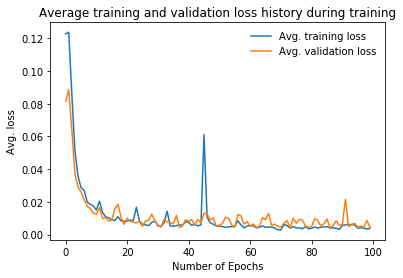

Trained net model no.: 2


In [20]:
# Visualize the training progress by plotting training and validation loss over the number of epochs
plt.plot(train_loss_history, label='Avg. training loss')
plt.plot(valid_loss_history, label='Avg. validation loss')
plt.title('Average training and validation loss history during training')
plt.xlabel('Number of Epochs'), plt.ylabel('Avg. loss')
plt.legend(frameon=False)
plt.show()
print('Trained net model no.: {}'.format(NET_MODEL_NO))

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [21]:
# get a sample of test data again using the last state of the trained net model
test_images, test_outputs, test_gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(test_gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


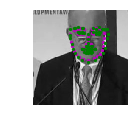

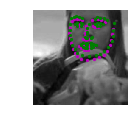

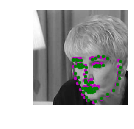

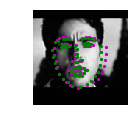

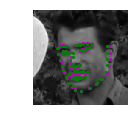

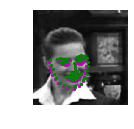

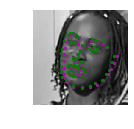

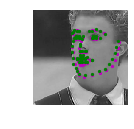

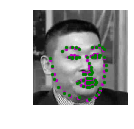

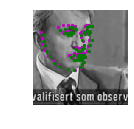

In [22]:
## TODO: visualize your test output using the last state of the trained net model
# you can use the same function as before, by un-commenting the line below:
visualize_output(test_images, test_outputs, test_gt_pts)

In [23]:
def test_net(test_loader, model, criterion, use_cuda):

    # evaluate test loss
    with torch.no_grad():
        
        # initialize running test loss
        running_test_loss = 0.0
        
        # set model to evaluation mode
        model.eval()
        
        # evaluate on batches of test data, assumes you already have test loader
        for batch_i, data in enumerate(test_loader):
            
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten keypoint array
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to float tensors for regression loss and move to cuda if available
            if use_cuda:
                key_pts = key_pts.type(torch.FloatTensor).cuda()
                images = images.type(torch.FloatTensor).cuda()
            else:
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)
            
            # forward pass to get predicted outputs
            output_pts = model(images)

            # calculate the test_batch_loss between predicted and target keypoints
            test_batch_loss = criterion(output_pts, key_pts)
            
            # convert current test_batch_loss into a scalar and add it to the avg. running_test_loss, use .item()
            running_test_loss = (running_test_loss * batch_i + test_batch_loss.item()) / (batch_i + 1)
    
        # Print overall average test loss
        print('Overall average test loss: {:.6f}\n'.format(running_test_loss))
    
    # Return overall average test lost
    return running_test_loss

In [24]:
# evaluate the last state of the trained net model on the test data set
test_loss = test_net(test_loader, net, criterion, use_cuda)

Overall average test loss: 0.003341



Once you've found a good model (or two), save your model so you can load it and use it later!

In [25]:
## TODO: change the name to something uniqe for each new model
#model_dir = 'saved_models/'
#model_name = 'keypoints_model.pt'

# after training, save your model parameters in the dir 'saved_models'
#torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: write your answer here (double click to edit this cell)

- Since this is a regression task (detecting facial features and finding their correct positions in the image) a loss function that is recommended for such tasks is likely a good choice. I have tested both MSELoss (mean squared error loss) and SmoothL1Loss criterion since both criteria are often used for regression tasks. SmoothL1Loss also incorporates a squared error term if the loss falls below a certain threshold, otherwise it uses L1 loss.  

- Experiments with the different net models I have tested show that SmoothL1Loss usually leads to better fits of the facial keypoints for this specific problem.  

- So SmoothL1Loss was the final choice due to the outcome.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: write your answer here

- I have started with a rather standard CNN structures with a feature detector block consisting of 3...5 convolutional layers (3x3 kernel size, stride = 1, padding = 1) with max pooling layers (kernel size = 2x2, stride = 2) and a classifier block with 2...3 fully connected linear layers. For the models no. 0 resp. no. 1 with 3 resp. 4 convolutional layers I have increased the stride of the convolutional filter kernel to stride = 2 for the last two resp. for the last convolutional layer in order to reduce memory demand on the GPU. All convolutional and linear layers are followed by a 2d resp. 1d batch normalization layer except for the output layer. In order to prevent overfitting and to decrease the chance to get trapped in local loss minima I have added dropout layers to each layer except for the output one with constant dropout probability of 20...30% or layer-dependent dropout probability increasing from 10% for the first convolutional layer up to 30% for the last convolutional layer and the fully connected layers. I have used relu activation functions for both convolutional and linear layers. I have also tried out elu functions with small negative part (alpha = 0.1) and leaky_relu functions with small negative slope = 0.01.  

- Overview on the tested models:

| Column 1 | Column 2 | Column 3 | Column 4 | Column 5 |
| :------: | :------: | :------: | :------: | :------: |
| model no. | 0 | 1 | 2 | 3 |
| link | [model_0](model_0.py) | [model_1](model_1.py) |  [model_2](model_2.py) | [model_3](model_3.py) | 
| convolutional layers | 3 | 4 | 5 | 5 |
| convolutional layer activation | relu | relu | relu | relu | elu |
| linear layers | 2 | 3 | 4 | 5 | 5 |
| linear layer activation | relu | relu | relu | relu | leaky relu |
| min. average training loss during training | 0.004638 (epoch 91) | 0.003101 (epoch 93) | 0.003869 (epoch 74) | 0.007898 (epoch 67) |
| min. average validation loss during training | 0.005817 (epoch 91) | 0.003398 (epoch 93) | 0.003908 (epoch 74) | 0.006551 (epoch 67) |
| avg. training loss of last state (after 100 epochs) | 0.005284 | (epoch 93) 0.003851 | 0.003875 | 0.036391 |
| avg. validation loss of last state (after 100 epochs) | 0.006588 | 0.003676 | 0.004382 | 0.037176 |
| avg. test loss of last state (after 100 epochs) | 0.006901 | 0.003295 | 0.003341 | 0.029736 |
| training time on GeForce GTX 970M GPU for 100 epochs | 18 min 1 s | 30 min 59 s | 40 min 46 s | 40 min 7 s |

- I have trained all 4 model variants 100 epochs for comparision. For model_3 I have repeated the training for 500 epochs to see if there is any noticable improvements. When increasing the number of training epochs from 100 to 500 the average loss on the test dataset dropped from 0.029736 to 0.002398. The effort for improvement is now growing overproportionally to the benefit. So I stuck with 100 training epochs. 

- The model with elu and leaky_relu activation functions and decreasing dropout probability from first to last convolutional layer seems to have the highest potential, but also requires strong training efforts and long training times.

- What concerns testing the trained detectors on the test data set the outcome is similar for the current state of training. Some facial features are not correctly detected resp. not detected in the right position as the detector misinterprets some folds in the face as eyes, for instance. In other cases predicted facial keypoints are scaled too small compared to the real face. Here we should have more training data to see further improvements on prediction quality. Most likely the deeper networks will have a the higher potential to improve when increasing the training data set.

- In many cases the training process ended up in some local minimum and saturated until I found out that the learning rate scheduler I have used caused the problem. Without the learning rate scheduler, which helped me in other problems, the training process converged much better here. So the learning rate scheduler seems to be a rather disturbing element causing the optimization process be trapped at some local minimum. So I have swiched it off.  

- With the same weight initialization method the results vary a lot. When repeating the same initialization method several times you may end up with higher or lower loss levels at the beginning and after the training. So the starting point of the optimzation is important when training only for a low number of epochs because it determines which local minima you may catch. I have tried out four different initialization methods, but for me the standard initialization method inbuilt in pytorch (without adding anything) worked best here. When increasing the number of epochs while making use of stochasitc regularization methods like dropout the effect of the initialization becomes less important. However, if you start with a low loss due to a good initialization you have less computational effort.  

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

- As I prefer working on my local machine I am limited by my GPU memory. So I have tried to increase batch size from 10 to 20, what lead to memory issues with the larger models. So I ended up on about 16 at maximum with my final model due to cuda memory limitations. With smaller models I can increase the batch size a little further.  

- I have started testing with 10...20 epochs comparing different models and often ending up with being trapped in some local minimum (due to the learning rate scheduler as it turned out).  

- When the model and optimization parameters seemed ok for me I have increased the number of epochs up to 500 for model no. 3 with elu and leaky_relu activation functions for this was harder to train. For the other models I went for 100 epochs. During training you have quite some loss fluktuations that may show sudden spikes that can really shoot up when dropout changes parameters, but there are often quite impressive improvements, too, with much lower losses as well.  

- In most cases the training leads to a quick drop in loss at the very beginning, but then the loss curve just saturates at some level fluctuating with hardly any trend to lower. However, though there is hardly any reduction in loss the convolutional filters still seem to continue to evolve because the results get better.  

- At the beginning of the training the convolutional filters behave like some kind of blurring filters. After some more training epochs they slowly turn into some kind of corner or edge detector. So therefore I conclude that facial keypoint detection often needs a longer training time.  

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.27509716 -0.21439241 -0.4311975 ]
 [ 0.20828032 -0.07815842 -0.28218907]
 [-0.40675527 -0.23812926 -0.12859456]]
(3, 3)


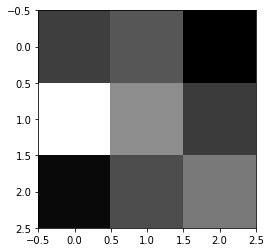

In [26]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1[0].weight.data.cpu() # net.conv1[0] => conv2d layer | net.conv1[1] => batch_norm layer

# convert weights from tensor to numpy array
w1 = weights1.numpy()

# First layer has 32 filter kernels of size 1 x 3 x 3
filter_index = 31 # 0...31 => second index is fixed to zero as there is only one gray/color channel

print(w1[filter_index][0])
print(w1[filter_index][0].shape)

# display the filter weights
plt.imshow(w1[filter_index][0], cmap='gray')

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

<function matplotlib.pyplot.show(*args, **kw)>

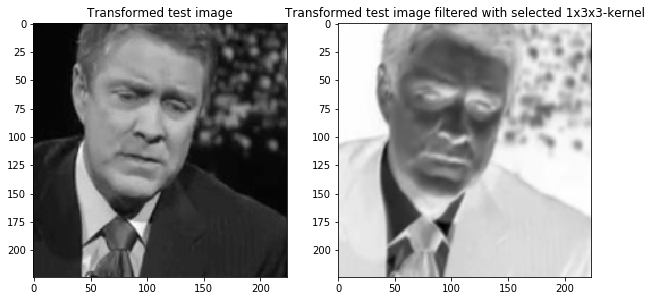

In [27]:
##TODO: load in and display any image from the transformed test dataset

# Get random sample batch from test loader
sample_batch = next(iter(test_loader)) # returns a list of dictionaries with the keys 'image' and 'keypoints'
image = sample_batch['image'][0].data # get first image from test sample batch
#print(image.size())

# un-transform the tensor format of the sample image and convert it back to numpy image format
image = image.numpy()                    # convert tensor to numpy array
image = np.transpose(image, (1, 2, 0))   # transpose image to go from torch to numpy image format
#print(image.shape)

# Plot the selected test image
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(image), cmap='gray')
plt.title('Transformed test image')

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

# Filter the image using filter2D, which has inputs: (grayscale image, bit-depth, kernel)  
w1_filtered_image = cv2.filter2D(image, -1, w1[filter_index][0])

# plot the filtered test image
ax = plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(w1_filtered_image), cmap='gray')
plt.title('Transformed test image filtered with selected 1x3x3-kernel')
plt.show

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

- The trained filter properties seem to depend heavily on the number of training cycles resp. epochs.  

- When the training process is run just for a few epochs the filter coefficients still resemble their random initialization state so that the filter effect is weak. It mainly leads to blurring effects when such a kernel is applied directly on the input image. 

- When the training process has evolved over a larger number of epochs the filters are turned into some kind of edge or corner detectors still combined with blurring effects. But this is not always the case.  

- The filters of the deeper layers are more like edge detectors. However, to shape their properties takes quite a while of training.  

In [28]:
# Plot in separate interactive figures to be able to zoom
#%matplotlib notebook
%matplotlib inline

In [29]:
# Make predictions on a sample batch of images returing activations, feature maps and layer outputs of the CNN model
def net_sample_outputs_per_layer():
    
    # Switch off gradients in net model for efficient evaluation
    with torch.no_grad():
        
        # Set model to evaluation mode (switch off dropout)
        net.eval()
        
        # Get random sample batch from test loader
        sample_batch = next(iter(test_loader)) # returns a list of dictionaries with the keys 'image' and 'keypoints'
        
        # get sample data of the first image of the batch: images and ground truth keypoints
        images = sample_batch['image']
        gt_key_pts = sample_batch['keypoints']
        
        # convert images to FloatTensors and move to cuda if available
        if use_cuda:
            images = images.type(torch.FloatTensor).cuda()
        else:
            images = images.type(torch.FloatTensor)
        
        # forward pass to get net output
        output_pts, activations, feature_maps, layer_outputs = net.predict(images)
        # output_pts, feature_maps = net.predict(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # Copy tensor of images, output_pts, activations, feature_maps and layer_outputs back to CPU if they are not there yet
        images = images.cpu()
        output_pts = output_pts.detach().cpu() # detach the tensors from the model graph
        for layer in activations.keys():
            activations[layer] = activations[layer].detach().cpu()
        for layer in feature_maps.keys():
            feature_maps[layer] = feature_maps[layer].detach().cpu()
        for layer in layer_outputs.keys():
            layer_outputs[layer] = layer_outputs[layer].detach().cpu()
        
        # Return batch of images, ground truth key points, predicted keypoints, activations, feaature maps and layer outputs
        return images, output_pts, activations, feature_maps, layer_outputs, gt_key_pts

In [30]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, \
test_output_pts, \
test_activations, \
test_feature_maps, \
test_layer_outputs, \
test_gt_pts = net_sample_outputs_per_layer()
# test_images, test_output_pts, test_feature_maps, test_gt_pts = net_sample_outputs_per_layer()

# print out the dimensions of the data to see if they make sense
print('Shape of input image batch tensor: \n{}'.format(test_images.data.size()))
print('Shape of predicted keypoints batch tensor: \n{}'.format(test_output_pts.data.size()))
print('Shape of ground truth keypoints batch tensor: \n{}'.format(test_gt_pts.size()))

Shape of input image batch tensor: 
torch.Size([16, 1, 224, 224])
Shape of predicted keypoints batch tensor: 
torch.Size([16, 68, 2])
Shape of ground truth keypoints batch tensor: 
torch.Size([16, 68, 2])


In [31]:
# print dictionary of activations
for layer in test_activations.keys():
    print('Shape of activation tensor in layer "{}": {}'.format(layer, test_activations[layer].shape))

Shape of activation tensor in layer "conv1": torch.Size([16, 32, 224, 224])
Shape of activation tensor in layer "conv2": torch.Size([16, 64, 112, 112])
Shape of activation tensor in layer "conv3": torch.Size([16, 128, 56, 56])
Shape of activation tensor in layer "conv4": torch.Size([16, 256, 28, 28])
Shape of activation tensor in layer "conv5": torch.Size([16, 512, 14, 14])
Shape of activation tensor in layer "fc1": torch.Size([16, 1024])
Shape of activation tensor in layer "fc2": torch.Size([16, 1024])


In [32]:
# print dictionary of feature maps
for layer in test_feature_maps.keys():
    print('Shape of feature maps tensor in layer "{}": {}'.format(layer, test_feature_maps[layer].shape))

Shape of feature maps tensor in layer "conv1": torch.Size([16, 32, 224, 224])
Shape of feature maps tensor in layer "conv2": torch.Size([16, 64, 112, 112])
Shape of feature maps tensor in layer "conv3": torch.Size([16, 128, 56, 56])
Shape of feature maps tensor in layer "conv4": torch.Size([16, 256, 28, 28])
Shape of feature maps tensor in layer "conv5": torch.Size([16, 512, 14, 14])


In [33]:
# print dictionary of layer outputs
for layer in test_layer_outputs.keys():
    print('Shape of layer outputs tensor in layer "{}": {}'.format(layer, test_layer_outputs[layer].shape))

Shape of layer outputs tensor in layer "pool_conv1": torch.Size([16, 32, 112, 112])
Shape of layer outputs tensor in layer "pool_conv2": torch.Size([16, 64, 56, 56])
Shape of layer outputs tensor in layer "pool_conv3": torch.Size([16, 128, 28, 28])
Shape of layer outputs tensor in layer "pool_conv4": torch.Size([16, 256, 14, 14])
Shape of layer outputs tensor in layer "pool_conv5": torch.Size([16, 512, 7, 7])
Shape of layer outputs tensor in layer "fc1": torch.Size([16, 1024])
Shape of layer outputs tensor in layer "fc2": torch.Size([16, 1024])


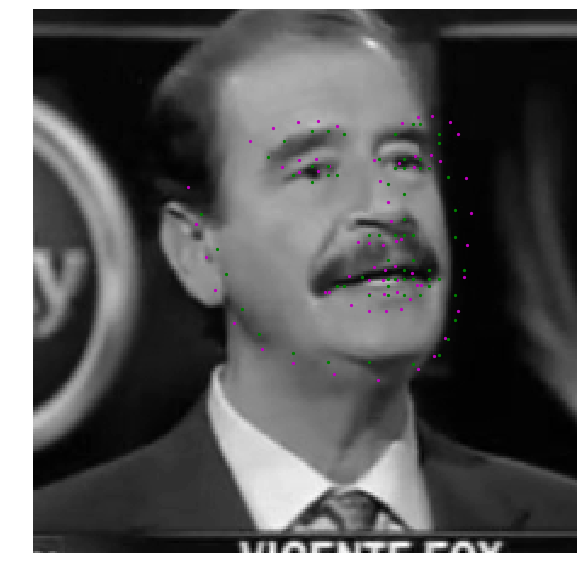

In [34]:
# visualize one batch of test images
visualize_output(test_images, test_output_pts, test_gt_pts, batch_size=1)

In [35]:
# visualize the activations of all convolutional hidden layers
# by default this shows a single-image-batch
def visualize_activations(activations, batch_size=1):

    # Loop over the batch
    for i in range(batch_size):
        
        # Loop over the activations of all hidden layers
        for layer in activations.keys():
            
            # Consider only convolutional layers
            if 'conv' in layer:
                
                # get the shape of the activations of the current convolutional layer
                #d, w, h = activations[layer][i].data.shape
                
                # un-transform the activations for each convolutional layer from tensor to numpy
                # print(activations[layer][i].data.shape)
                amaps = activations[layer][i].data # get the activations of ith layer
                amaps = amaps.numpy() # convert activations from tensor to numpy 
                amaps = np.transpose(amaps, (1, 2, 0)) # transpose to go from torch tensor to numpy image format
                activations[layer] = amaps # write un-transformed activations back to dictionary
                # print(amaps.shape)
                
                # get the shape of the activations of the current convolutional layer
                w, h, d = amaps.shape
                
                # Get optimal arrangement of the activation images for each convolutional layer in the plot
                cols = int(np.power(2, np.floor(np.log2(np.sqrt(d)))))
                rows = int(d / cols)
                
                # Initialize activations image
                amaps_image = np.zeros((h * rows, w * cols))
                
                # Loop over all activations of the current convolutional layer
                for row_idx in range(rows):
                    for col_idx in range(cols):
                        idx = row_idx * cols + col_idx
                        amaps_image[row_idx*h:(row_idx+1)*h,col_idx*w:(col_idx+1)*w] = amaps[:, :, idx]
                
                # Show all the activations of the current convolutional layer in a new single plot
                plt.figure(figsize=(20,10))
                plt.imshow(amaps_image, cmap='gray')
                plt.axis('off')
                plt.title('Activations of convolutional layer "{}" of shape w x h x d = {} x {} x {}'.format(layer,
                                                                                                         w, h, d))
    # Show all plots
    plt.show()

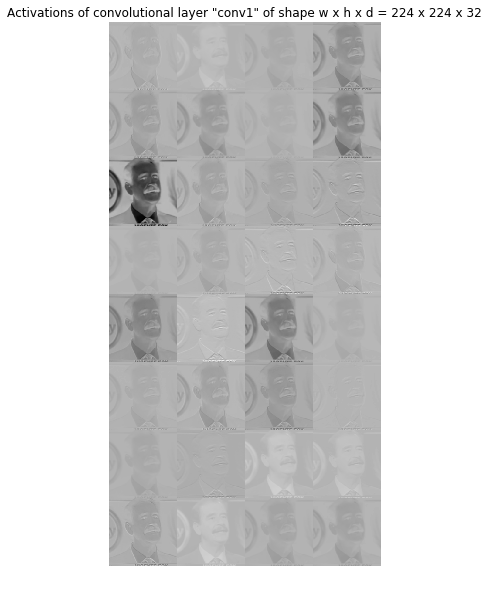

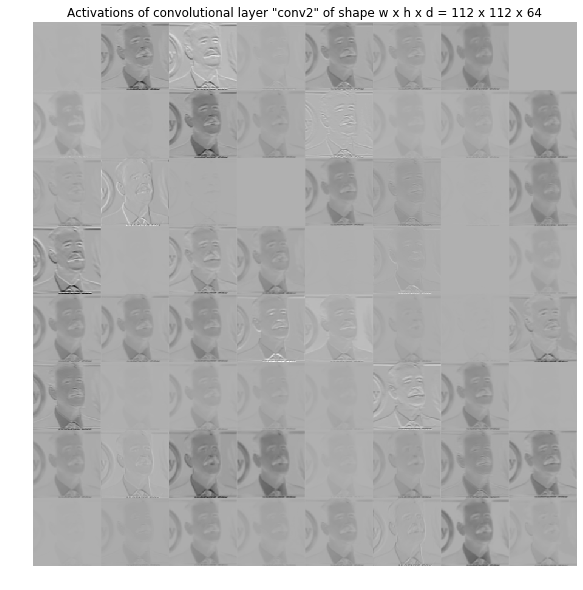

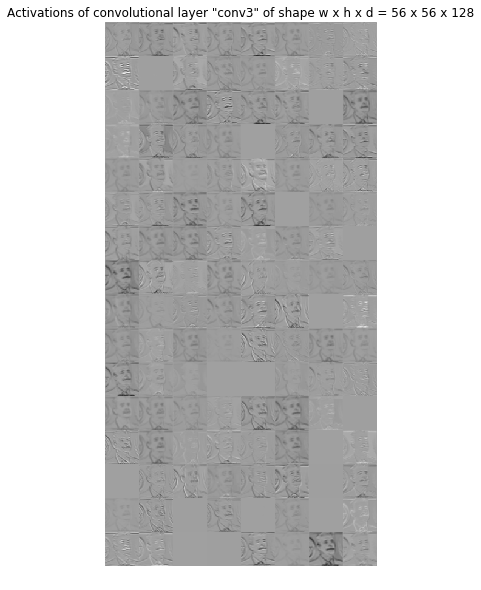

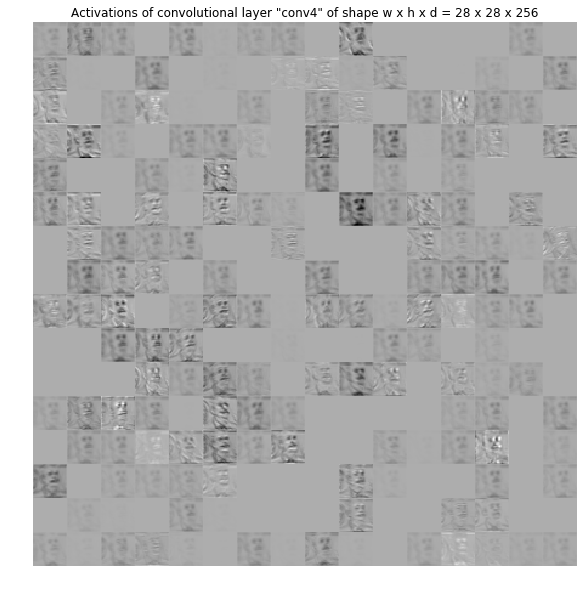

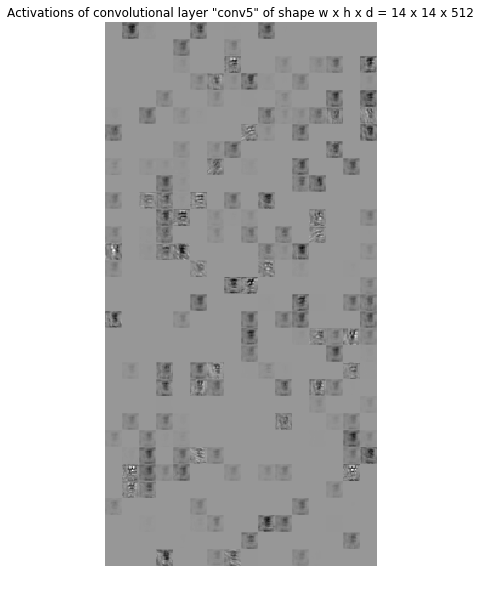

In [36]:
# Visualize the activations of all hidden layers of the net model resulting from the test image input
visualize_activations(test_activations)

In [37]:
# visualize the feature maps of all convolutional layers
# by default this shows a single-image-batch
def visualize_feature_maps(feature_maps, batch_size=1):

    # Loop over the batch
    for i in range(batch_size):
        
        # Loop over the feature maps of all convolutional layers
        for layer in feature_maps.keys():
                        
            # Consider only convolutional layers
            if 'conv' in layer:
                
                # get the shape of the feature maps of the current convolutional layer
                #d, w, h = feature_maps[layer][i].data.shape
                
                # un-transform the feature maps for each layer from tensor to numpy
                # print(feature_maps[layer][i].data.shape)
                fmaps = feature_maps[layer][i].data # get the feature maps of ith layer
                fmaps = fmaps.numpy() # convert feature maps from tensor to numpy 
                fmaps = np.transpose(fmaps, (1, 2, 0)) # transpose to go from torch tensor to numpy image format
                feature_maps[layer] = fmaps # write un-transformed feature maps back to dictionary
                
                # get the shape of the feature maps of the current convolutional layer
                w, h, d = fmaps.shape
                
                # Get optimal arrangement of the feature maps for each convolutional layer in the plot
                cols = int(np.power(2, np.floor(np.log2(np.sqrt(d)))))
                rows = int(d / cols)
                
                # Initialize feature maps image
                fmaps_image = np.zeros((h * rows, w * cols))
                
                # Loop over all feature maps of the current convolutional layer
                for row_idx in range(rows):
                    for col_idx in range(cols):
                        idx = row_idx * cols + col_idx
                        fmaps_image[row_idx*h:(row_idx+1)*h,col_idx*w:(col_idx+1)*w] = fmaps[:, :, idx]
            
                # Show all the feature maps of the current convolutional layer in a new single plot
                plt.figure(figsize=(20,10))
                plt.imshow(fmaps_image, cmap='gray')
                plt.axis('off')
                plt.title('Feature maps of convolutional layer "{}" of shape w x h x d = {} x {} x {}'.format(layer,
                                                                                                         w, h, d))
    # Show all plots  
    plt.show()

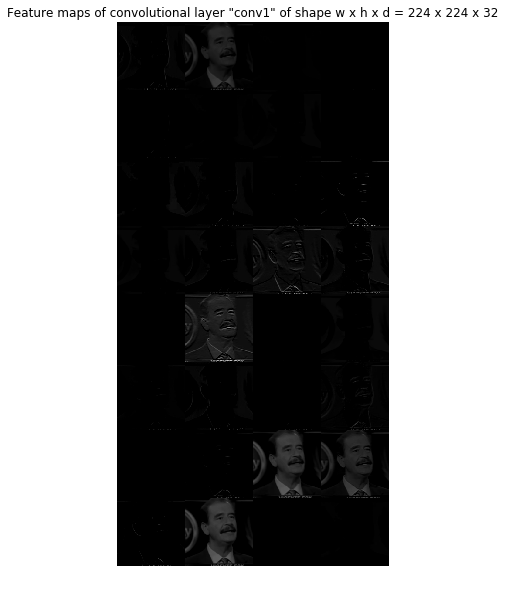

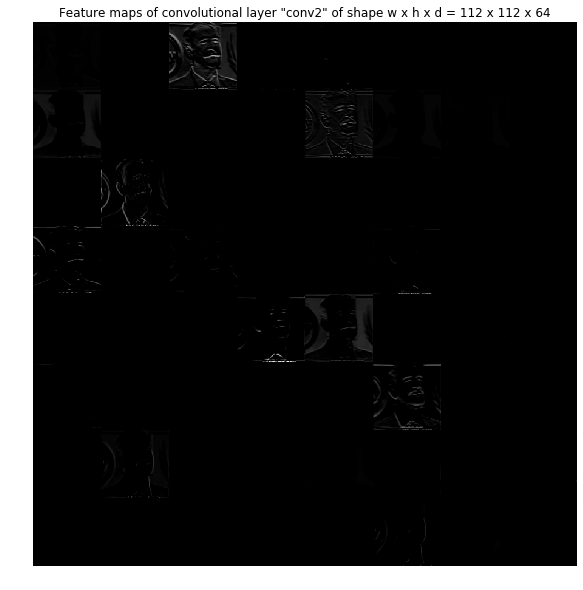

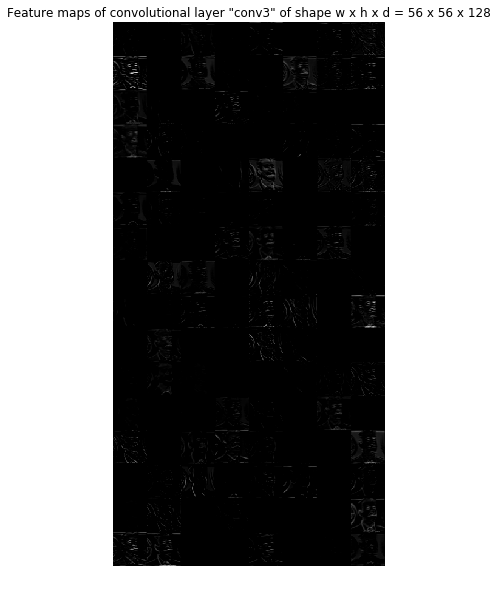

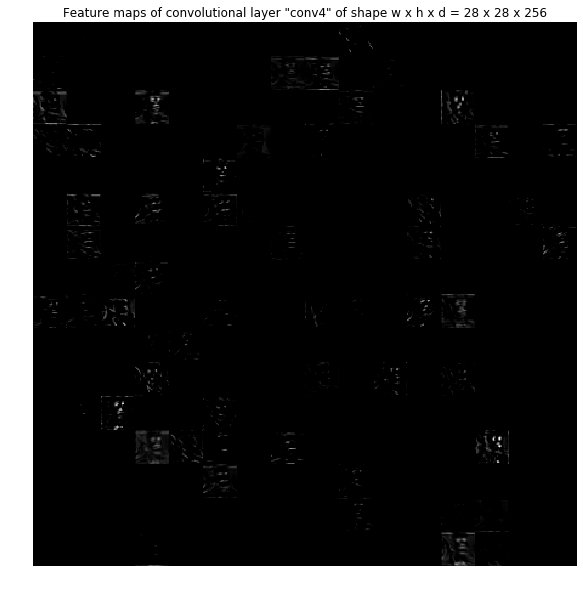

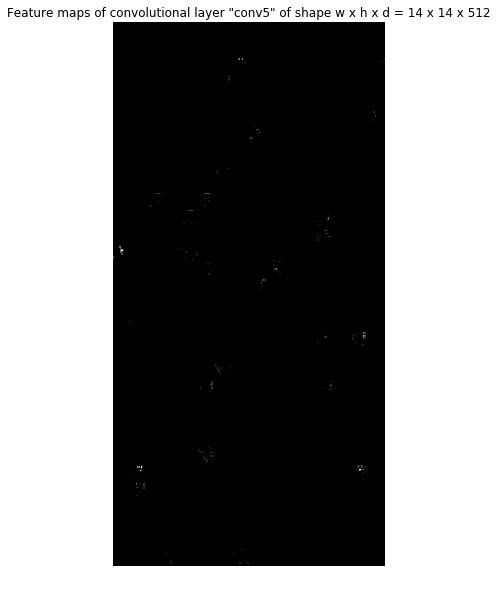

In [38]:
# Visualize the feature maps of all convolutional layers of the net model resulting from the test image input
visualize_feature_maps(test_feature_maps)

In [39]:
# visualize the layer outputs of all convolutional hidden layers
# by default this shows a single-image-batch
def visualize_layer_outputs(layer_outputs, batch_size=1):

    # Loop over the batch
    for i in range(batch_size):
        
        # Loop over the layer outputs of all convolutional layers
        for layer in layer_outputs.keys():
            
            # Consider only convolutional layers
            if 'conv' in layer:
                
                # get the shape of the layer outputs of the current convolutional layer
                d, w, h = layer_outputs[layer][i].data.shape
                
                # un-transform the layer outputs for each convolutional layer from tensor to numpy
                # print(layer_outputs[layer][i].data.shape)
                lomaps = layer_outputs[layer][i].data # get the layer outputs of ith layer
                lomaps = lomaps.numpy() # convert layer outputs from tensor to numpy 
                lomaps = np.transpose(lomaps, (1, 2, 0)) # transpose to go from torch tensor to numpy image format
                layer_outputs[layer] = lomaps # write un-transformed layer outputs back to dictionary
                
                # get the shape of the layer outputs of the current convolutional layer
                w, h, d = lomaps.shape
                
                # Get optimal arrangement of the layer output images for each convolutional layer in the plot
                cols = int(np.power(2, np.floor(np.log2(np.sqrt(d)))))
                rows = int(d / cols)
                
                # Initialize layer outputs image
                lomaps_image = np.zeros((h * rows, w * cols))
                
                # Loop over all layer outputs of the current convolutional layer
                for row_idx in range(rows):
                    for col_idx in range(cols):
                        idx = row_idx * cols + col_idx
                        lomaps_image[row_idx*h:(row_idx+1)*h,col_idx*w:(col_idx+1)*w] = lomaps[:, :, idx]
                
                # Show all the feature maps of the current layer in a new single plot
                plt.figure(figsize=(20,10))
                plt.imshow(lomaps_image, cmap='gray')
                plt.axis('off')
                plt.title('Layer outputs of convolutional layer "{}" of shape w x h x d = {} x {} x {}'.format(layer,
                                                                                                         w, h, d))
    # Show all plots  
    plt.show()

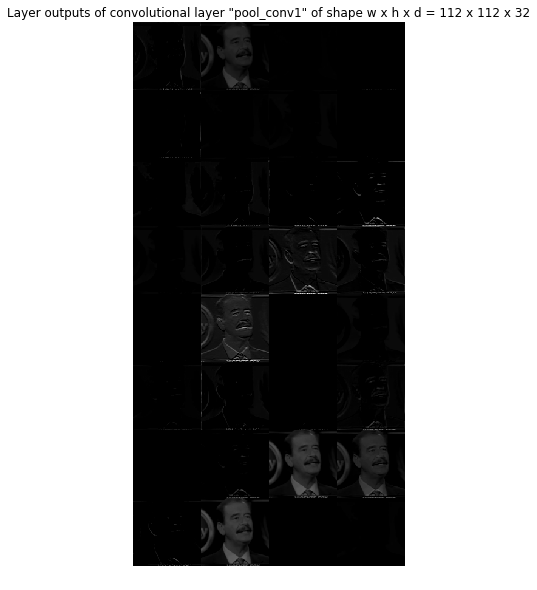

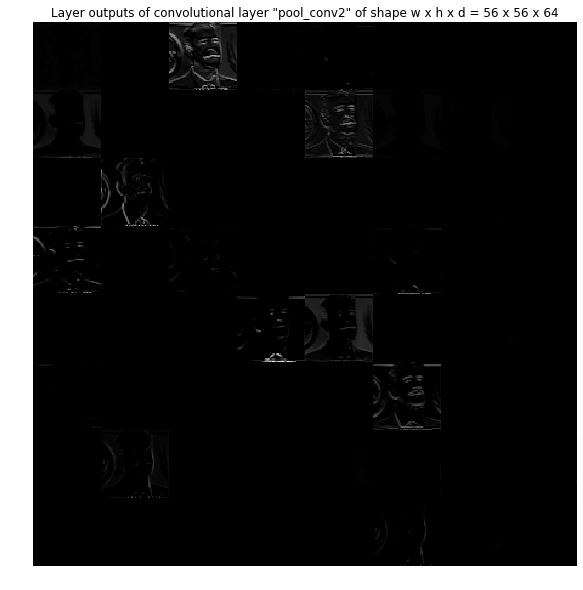

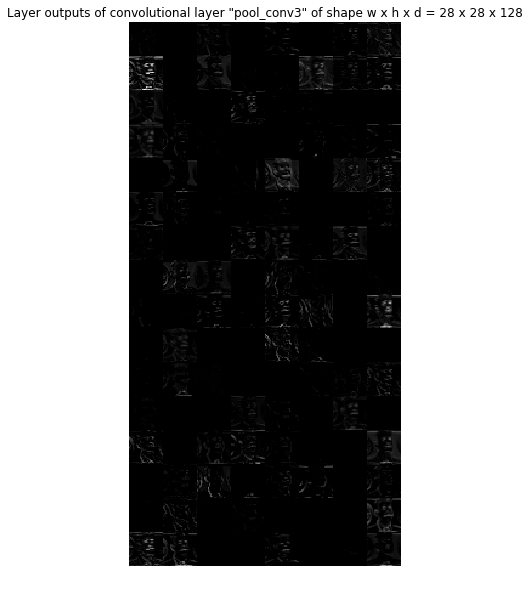

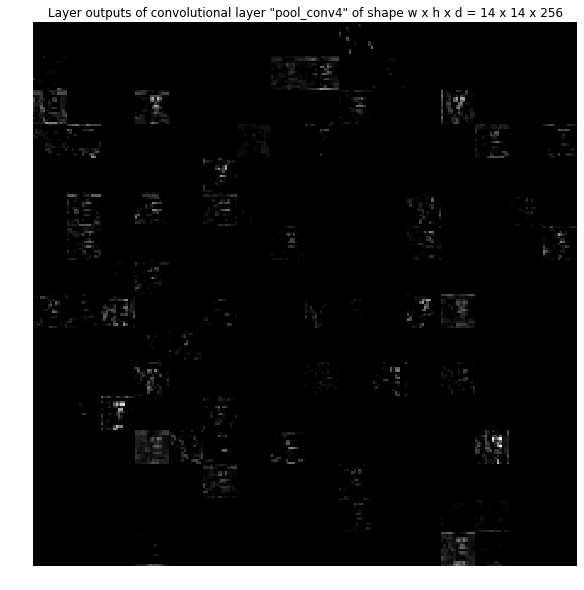

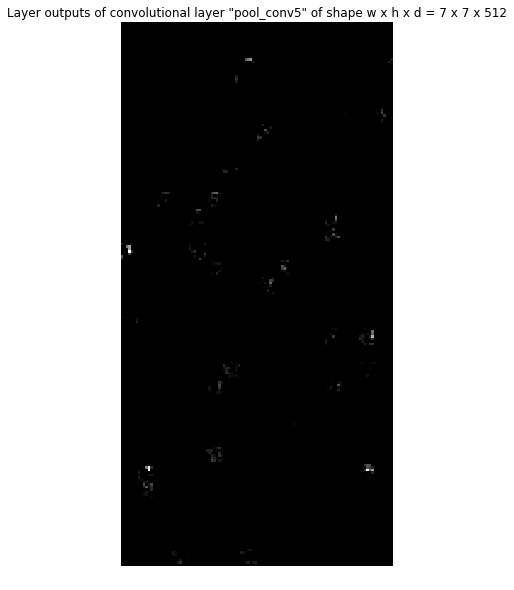

In [40]:
# Visualize the layer outputs of all convolutional layers of the net model resulting from the test image input
visualize_layer_outputs(test_layer_outputs)

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!